# TensorFlow 教程 #07
# Inception 模型

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)  
中文翻译 [thrillerist](https://zhuanlan.zhihu.com/insight-pixel)/[Github](https://github.com/thrillerist/TensorFlow-Tutorials)

## 介绍

这篇教程演示了如何用一个预训练好的深度神经网络Inception v3来进行图像分类。

Inception v3模型在一台配有 8 Tesla K40 GPUs，大概价值$30,000的野兽级计算机上训练了几个星期，因此不可能在一台普通的PC上训练。我们将会下载预训练好的Inception模型，然后用它来做图像分类。

Inception v3模型大约有2500万个参数，分类一张图像就用了50亿的乘加指令。在一台没有GPU的现代PC上，分类一张图像转眼就能完成。

这篇教程隐藏了TensorFlow代码，因此可能不要求很多的TensorFlow经验，当然从之前的教程中学到一些对TensorFlow的基本理解还是很有帮助的，特别是在你想学习`inception.py`文件中的实现细节时。

## 流程图

下面的流程图显示了Inception v3模型中的数据流向，这是一个带有许多层的，有着复杂结构的卷积神经网络。这篇[论文](http://arxiv.org/pdf/1512.00567v3.pdf)里有Inception模型如何构造，以及为什么这么设计的更多细节。但作者也承认他们并不完全明白模型的工作原理。

注意，Inception模型有两个softmax输出。一个是在训练神经网络时使用，另一个是训练结束之后，在图像分类时使用，即推断阶段（inference）。

上周刚刚分布了[新的模型](https://research.googleblog.com/2016/08/improving-inception-and-image.html)， 它比Inception v3更复杂，也得到了更好的分类准确率。

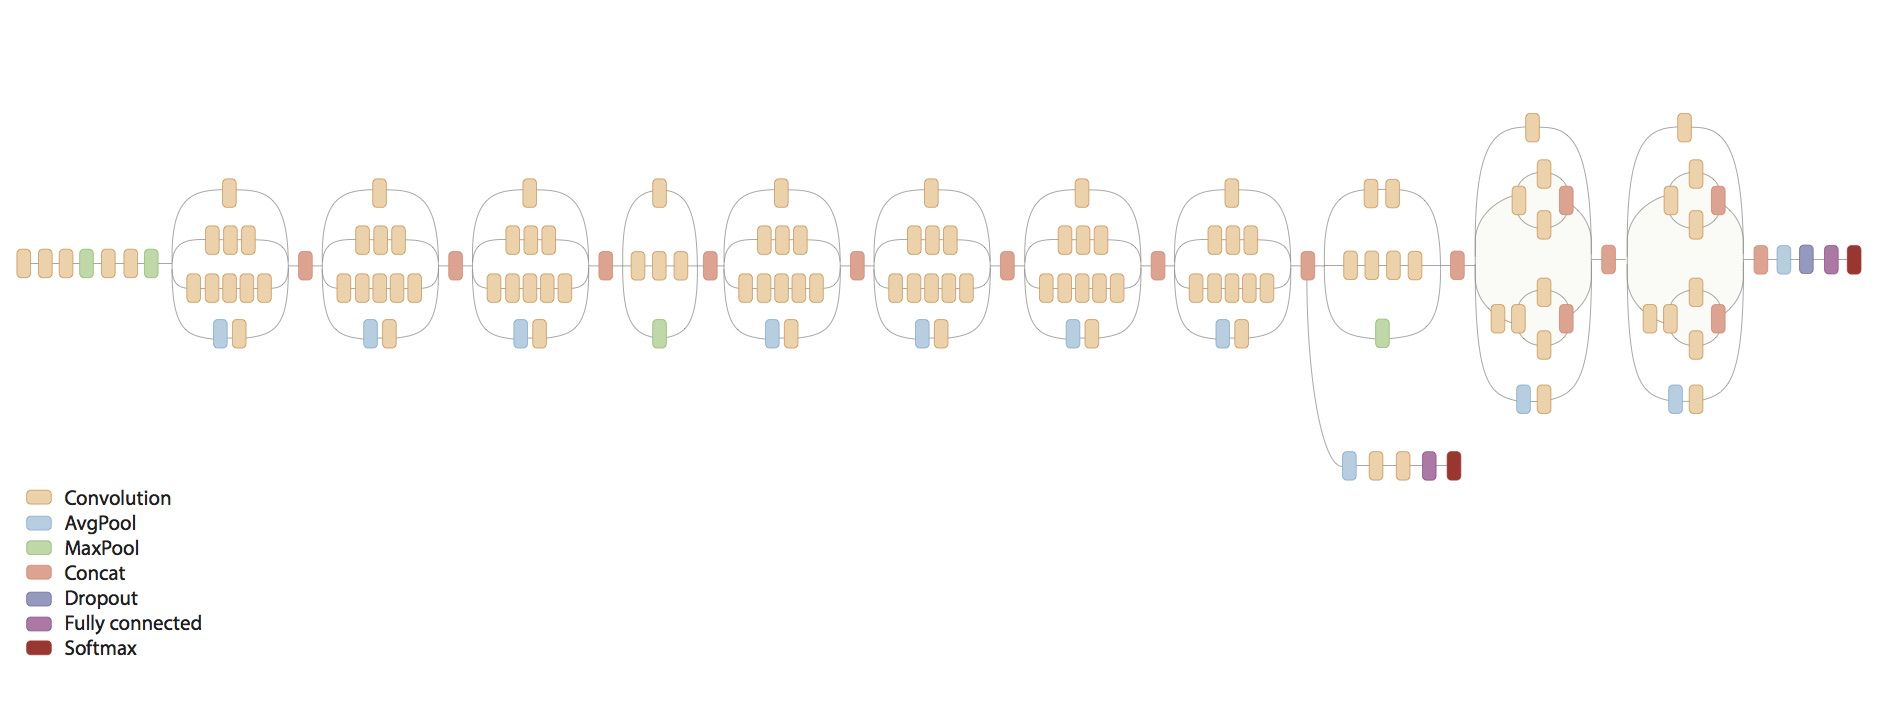

In [1]:
from IPython.display import Image, display
Image('images/07_inception_flowchart.png')

## 导入

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Functions and classes for loading and using the Inception model.
import inception

使用Python3.5.2（Anaconda）开发，TensorFlow版本是：

In [3]:
tf.__version__

'1.6.0'

## 下载Inception模型

从网上下载Inception模型。这是你保存数据文件的默认文件夹。如果文件夹不存在就自动创建。

In [4]:
# inception.data_dir = 'inception/'

如果文件夹中不存在Inception模型，就自动下载。  
它有85MB。

In [4]:
inception.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


## 载入Inception模型

载入模型，为图像分类做准备。

注意这些warning信息，以后可能会导致程序运行失败。

In [5]:
model = inception.Inception()

## 分类以及绘制图像的帮助函数

这是一个简单的封装函数，它可以展示图像，然后用Inception模型进行分类，最终打印出分类评分。

In [6]:
def classify(image_path):
    # Display the image.
    display(Image(image_path))

    # Use the Inception model to classify the image.
    pred = model.classify(image_path=image_path)

    # Print the scores and names for the top-10 predictions.
    model.print_scores(pred=pred, k=10, only_first_name=True)    

## 熊猫

Inception数据文件中包含了这张熊猫图像。Inception模型相当确定这张图片上展示了熊猫，分类评分达到了89.63%，第二高的代表大狐猴的分数只有0.77%，这是另外一种外来动物。

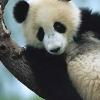

89.63% : giant panda
 0.77% : indri
 0.27% : lesser panda
 0.14% : custard apple
 0.10% : earthstar
 0.08% : sea urchin
 0.05% : forklift
 0.05% : go-kart
 0.04% : soccer ball
 0.04% : sports car


In [7]:
image_path = os.path.join(inception.data_dir, 'cropped_panda.jpg')
classify(image_path)

## 分类评分的解释

Inception模型的输出是Softmax函数，这在之前教程中的神经网络中也有用到。

softmax输出有时也称为概率分布（probabilities），因为它介于零到一之间，然后相加为一，与概率分布相同。但它们并不是传统语义上的概率分布，因为并不是由重复试验得来。

将神经网络的输出值称为分类评分或排名可能会更好，因为结果显示了神经网络认为输入图像是每个可能分类的强度。

在上面的熊猫样本中， Inception模型给熊猫类型很高的分数—89.63%，同时其它999种类别的分数都在1%以下。这表示Inception模型十分确信图像展示了一只熊猫，而剩下1%以下的应该视为噪声。比如，排名第十高的分数是0.05%，代表电子手表，但它更可能是由于神经网络的不精准而不是暗示着图像看起来有点像电子手表。

有时Inception模型不确定图像属于哪一个分类，因此结果中并没有一个特别高的分数。下面会展示这种样本。

## 鹦鹉（原始图像）

Inception模型十分确定（评分97.18%）这张图像展示了一种叫金刚鹦鹉的鹦鹉。

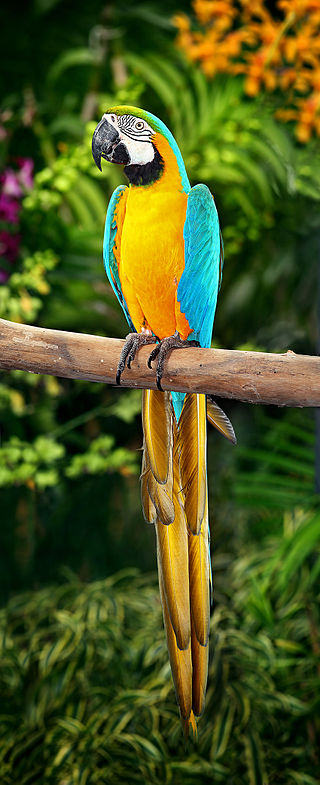

97.18% : macaw
 0.07% : African grey
 0.06% : toucan
 0.05% : jacamar
 0.04% : bee eater
 0.03% : lorikeet
 0.02% : sulphur-crested cockatoo
 0.02% : jay
 0.01% : kite
 0.01% : indigo bunting


In [11]:
classify(image_path="images/parrot.jpg")

## 鹦鹉（调整图像）

Inception使用于299 x 299像素的输入图像。上面的鹦鹉图像实际上是320像素宽、785像素高的，因此它将由Inception模型自动缩放。

现在我们想看看被Inception模型调整过的图像。

首先我们实现一个帮助函数，用来从Inception模型内部获取调整过的图像。

In [12]:
def plot_resized_image(image_path):
    # Get the resized image from the Inception model.
    resized_image = model.get_resized_image(image_path=image_path)

    # Plot the image.
    plt.imshow(resized_image, interpolation='nearest')
    
    # Ensure that the plot is shown.
    plt.show()

现在画出调整过的鹦鹉图。这是Inception模型中神经网络的真正输入图像。我们可以看到它被压缩成正方形，并且分辨率降低了，因此图像看起来更像素化和锯齿状。

这种情况下，图像仍然清晰地展示了一只鹦鹉，但一些图像经过（模型内）原生的调整后会变得扭曲，因此你可能会想自己调整图像大小，再输入到Inception模型。

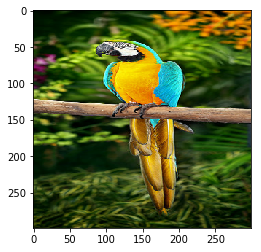

In [13]:
plot_resized_image(image_path="images/parrot.jpg")

## 鹦鹉（裁剪图像，上方）

鹦鹉图像被手动裁剪成299 x 299像素大小，然后输入到Inception模型中，这时（模型）还是很确信（评分97.52%）输入图展示了一只鹦鹉（金刚鹦鹉）。

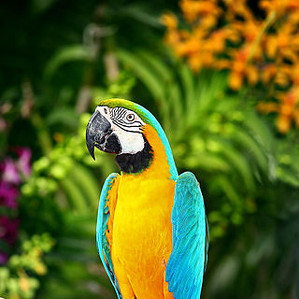

97.52% : macaw
 0.09% : African grey
 0.03% : sulphur-crested cockatoo
 0.02% : toucan
 0.02% : reflex camera
 0.01% : comic book
 0.01% : backpack
 0.01% : bib
 0.01% : vulture
 0.01% : lens cap


In [14]:
classify(image_path="images/parrot_cropped1.jpg")

## 鹦鹉（裁剪图像，中间）

这是鹦鹉图的另一张裁剪图像，这次展示了鹦鹉的躯干，不包含头部和尾巴。Inception模型仍然很确定（评分94.22%）这是一只金刚鹦鹉。

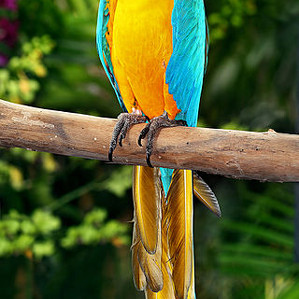

94.22% : macaw
 0.76% : toucan
 0.58% : African grey
 0.11% : jacamar
 0.10% : sulphur-crested cockatoo
 0.10% : bee eater
 0.09% : magpie
 0.08% : jay
 0.06% : lorikeet
 0.04% : hornbill


In [16]:
classify(image_path="images/parrot_cropped2.jpg")

## 鹦鹉（裁剪图像，底部）

这次的裁剪图像只显示了鹦鹉的尾巴。现在Inception模型相当困惑，认为图像可能显示的是一只鶲鴷（评分26.11%），这是另一种外来鸟，也可能是一只草蜢（评分10.61%）。

Inception模型还认为图像有可能是一只钢笔（评分2%）。但这是一个很低的分数，应该解释成不可靠的噪声。

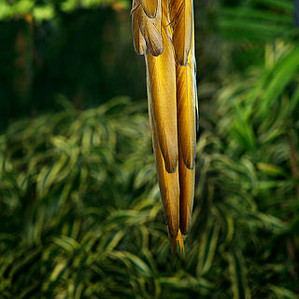

26.11% : jacamar
10.61% : grasshopper
 4.05% : chime
 2.24% : bulbul
 2.00% : fountain pen
 1.60% : leafhopper
 1.26% : cricket
 1.25% : kite
 1.13% : macaw
 0.80% : torch


In [14]:
classify(image_path="images/parrot_cropped3.jpg")

## 鹦鹉（填充图像）

对Inception模型来说，最好的输入图像方式是先将图像填充成正方形，然后调整至299 x 299像素，在这样的鹦鹉样本中，模型正确分类并且评分达到96.78%。


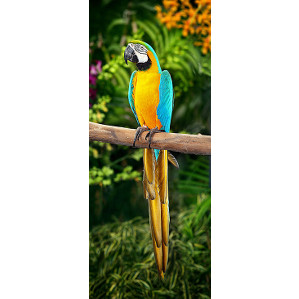

96.78% : macaw
 0.06% : toucan
 0.06% : African grey
 0.05% : bee eater
 0.04% : sulphur-crested cockatoo
 0.03% : king penguin
 0.03% : jacamar
 0.03% : lorikeet
 0.01% : kite
 0.01% : anemone fish


In [15]:
classify(image_path="images/parrot_padded.jpg")

## Elon Musk (299 x 299 像素)

这张图像展示了Elon Musk——活着的传奇，超级-书呆子-英雄。但Inception模型对图像显示的东西很困惑，它预测图像可能是一件运动衫（评分19.73%），或者是一件阿拉伯长袍（评分16.82）。它也认为图像可能是一个乒乓球（3.05%）或一个棒球（评分1.86%）。Inception模型很困惑，并且分类评分不可靠。

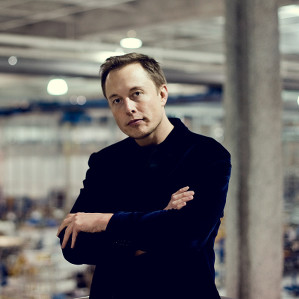

19.73% : sweatshirt
16.82% : abaya
 4.17% : suit
 3.46% : trench coat
 3.05% : ping-pong ball
 1.92% : cellular telephone
 1.86% : baseball
 1.77% : jersey
 1.54% : kimono
 1.43% : water bottle


In [16]:
classify(image_path="images/elon_musk.jpg")

## Elon Musk (100 x 100 像素)

如果我们使用100 x 100像素的Elon Mask图像，这时Inception模型认为它可能是一件运动衫（评分17.85%）， 或是一只牛仔靴（评分16.36%）。现在Inception模型做出了一些不同的预测，但仍然很困惑。

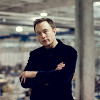

17.85% : sweatshirt
16.36% : cowboy boot
10.68% : balance beam
 8.87% : abaya
 5.36% : suit
 4.57% : Loafer
 2.94% : trench coat
 2.65% : maillot
 1.87% : jersey
 1.42% : unicycle


In [17]:
classify(image_path="images/elon_musk_100x100.jpg")

Inception模型自动将图像从100 x 100放大至299 x 299像素，如下所示。看看它是多么像素化和锯齿状，尽管人类可以轻易地看出这是一张双臂交叉的男人的图像。

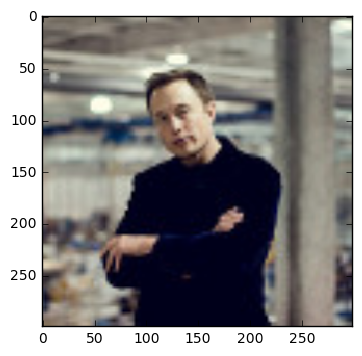

In [18]:
plot_resized_image(image_path="images/elon_musk_100x100.jpg")

## 查理和巧克力工厂 (Gene Wilder)

这张图像展示了在1971版电影《查理和巧克力工厂》中演员Gene Wilder饰演的角色。Inception模型很确定图像显示了一个蝴蝶领结（评分97.22%），尽管这是对的，但人类很可能说这张图片展示的是一个人。

原因可能是Inception模型在训练时将戴蝴蝶结的人的图像分类成蝴蝶领结而不是一个人。因此，或许类别名称应该改成“戴蝴蝶领结的人”而不只是“蝴蝶领结”。

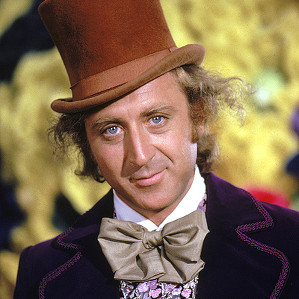

97.22% : bow tie
 0.92% : cowboy hat
 0.21% : sombrero
 0.09% : suit
 0.06% : bolo tie
 0.05% : Windsor tie
 0.04% : cornet
 0.03% : flute
 0.02% : banjo
 0.02% : revolver


In [19]:
classify(image_path="images/willy_wonka_old.jpg")

## 查理和巧克力工厂 (Johnny Depp)

这张图像展示了在2005版电影《查理和巧克力工厂》中演员Johnny Depp饰演的角色。Inception模型认为图像是“太阳镜（sunglasses）”（评分31.48%）或“太阳镜（sunglass）”（评分18.77）。实际上，第一个类别的全名是“太阳镜，深色眼镜，墨镜”。出于某些原因，Inception模型被训练成可以识别两种相似的眼镜。再一次，图像显示了太阳镜，这个结果是对的，但人类很可能会说图像展示的是一个人。

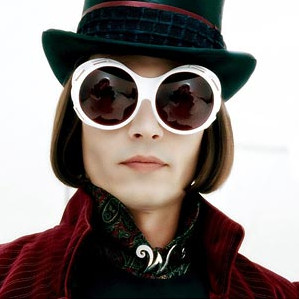

31.48% : sunglasses
18.77% : sunglass
 1.55% : velvet
 1.02% : wig
 0.77% : cowboy hat
 0.69% : seat belt
 0.67% : sombrero
 0.62% : jean
 0.46% : poncho
 0.43% : jersey


In [20]:
classify(image_path="images/willy_wonka_new.jpg")

## 关闭TensorFlow会话


现在我们已经用TensorFlow完成了任务，关闭session，释放资源。注意，TensorFlow-session是在模型内部的，因此我们通过模型来关闭它。

In [21]:
# This has been commented out in case you want to modify and experiment
# with the Notebook without having to restart it.
# model.close()

## 总结

本教程说明了如何使用预训练的Inception v3模型。它在一台野兽级电脑上花了好几周才训练好。但我们可以从网上下载完成的模型，然后在一台普通PC上用它来做图像分类。

不幸的是，Inception模型对识别人物很有问题。这可能是所使用训练集的原因。新版的Inception模型也已经发布了，但它可能也是在同样的训练集上训练，对于识别人物还是有问题。希望未来的模型会训练来识别常见的物体，比如人类。

这篇教程中我们在`inception.py`文件中隐藏了TensorFlow的实现细节，因为它有点凌乱，我们可能在之后的教程中仍然会复用这个。希望TensorFlow的开发者会标准化、简单化API，使得更简单地载入这些预训练模型，这样，每个人只需要几行代码就能使用一个强大的图像分类器。

## 练习

下面是一些可能会让你提升TensorFlow技能的一些建议练习。为了学习如何更合适地使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行改变之前，可能需要先备份一下。

* 使用你自己的、或者在网上找到的图像。
* 裁剪，调整大小，扭曲图像，看看它如何影响分类准确率。
* 在代码的几个不同地方加入打印信息。你也可以直接运行调试`inception.py`文件。
* 试着使用这些刚发布的[新模型](https://research.googleblog.com/2016/08/improving-inception-and-image.html)。它们的载入方式与Inception v3模型不同，实现起来可能更具挑战性。
* 向朋友解释程序如何工作。

## License (MIT)

Copyright (c) 2016 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.